<a href="https://colab.research.google.com/github/YeojinKim03/AI-study/blob/master/220809_AI_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoEncoder를 사용한 이상탐지

정상인 데이터들 중에 소수의 비정상인 데이터가 포함되어 있다.

AutoEncoder를 사용하여 학습 시킨다.

이렇게 학습된 AutoEncoder는 대부분의 정상 데이터에 대하여 복원 능력이 있다. 하지만 소소의 비정상 데이터에 대해서는 제대로 복원하지 못한다.

이렇게 학습시킨 AutoEncoder를 가지고 특정영상을 복원 하게 하고 그 복원 결과가 좋지 않을 경우 정상영상이 아니라고 판정한다.

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras import backend as K
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import random
import pickle
import cv2
import matplotlib


##데이터 준비 

###데이터 로딩

In [ ]:
((trainX, trainY), (testX, testY)) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


##데이터셋 생성
1의 레이블 영상이 정상이고 3의 레이블 영상이 비정상으로 한다.
<br>
정상 영상과 비정상 영상의 비율을 100:1로 해서 골라내고, 골고루 섞은 데이터셋을 만든다.

In [ ]:
def build_unsupervised_dataset(data, labels, validLabel=1, anomalyLabel=3, contam=0.01, seed=42):

  # 레이블 1인 영상의 인덱스
	validIdxs = np.where(labels == validLabel)[0]
  # 레이블 3인 영상의 인덱스
	anomalyIdxs = np.where(labels == anomalyLabel)[0]

  # 무작위로 섞어 주고
	random.shuffle(validIdxs)
	random.shuffle(anomalyIdxs)

  # 비정상 데이터의 갯수를 비정상 데이터 갯수 대비 0.01(contam)로 한다.
	i = int(len(validIdxs) * contam)
	anomalyIdxs = anomalyIdxs[:i]

	print("len(validIdx)=",len(validIdxs))
	print("len(anomalyIdxs)=",len(anomalyIdxs))

  # 추려낸 정상 데이터와 비정상 제이터
	validImages = data[validIdxs]
	anomalyImages = data[anomalyIdxs]

  # 두개의 데이터를 합하고, 다시 섞어주고
	images = np.vstack([validImages, anomalyImages])
	np.random.seed(seed)
	np.random.shuffle(images)

	return images

images = build_unsupervised_dataset(trainX, trainY, validLabel=1, anomalyLabel=3, contam=0.01)

len(validIdx)= 6742
len(anomalyIdxs)= 67


In [ ]:
print(images.shape)
print(np.max(images))
print(np.min(images))

(6809, 28, 28)
255
0


##데이터 모양 변경, Normalization
Conv2D 사용을 위해 데이터 모양을 (H, W, channel)의 3차원으로 만들고 (28, 28) -> (28, 28, 1)
<br>
0 ~ 1.0으로 normlaization 한다

In [ ]:
images = np.expand_dims(images, axis=-1)
images = images.astype("float32") / 255.0

In [ ]:
print(images.shape)
print(np.max(images))
print(np.min(images))

(6809, 28, 28, 1)
1.0
0.0


##데이터 분리

In [ ]:
(trainX, testX) = train_test_split(images, test_size=0.2, random_state=42)

In [ ]:
print(trainX.shape)
print(testX.shape)

(5447, 28, 28, 1)
(1362, 28, 28, 1)


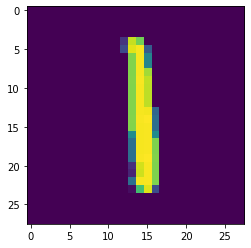

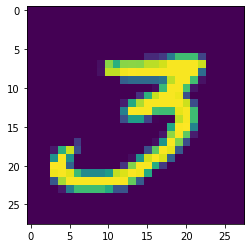

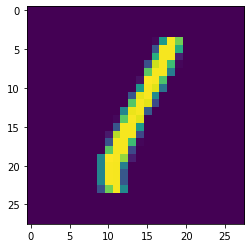

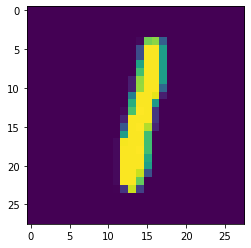

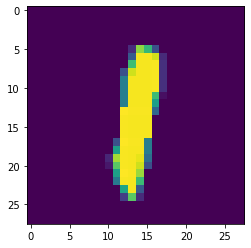

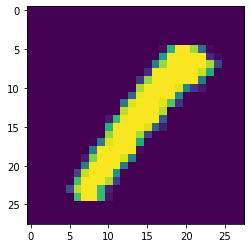

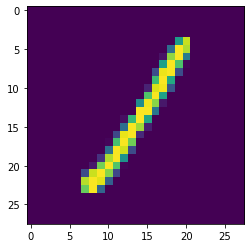

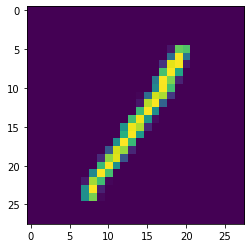

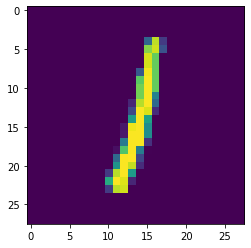

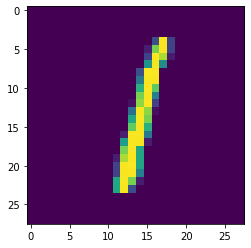

In [ ]:
for i in range(10):
  plt.imshow(trainX[i].reshape((28,28)))
  plt.show()

##학습

###모델 정의

In [ ]:
class ConvAutoencoder:

	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		inputShape = (height, width, depth)
		chanDim = -1

		inputs = Input(shape=inputShape)
		x = inputs

		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)

		encoder = Model(inputs, latent, name="encoder")




		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)

		decoder = Model(latentInputs, outputs, name="decoder")



		autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")


		return autoencoder

###모델 생성

In [ ]:
autoencoder = ConvAutoencoder.build(28, 28, 1)
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69392     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         109377    
                                                                 
Total params: 178,769
Trainable params: 178,385
Non-trainable params: 384
_________________________________________________________________


###모델 컴파일

In [ ]:
# decay값은 1 step 마다 감소하는 비율
opt = Adam(learning_rate=1e-3, decay=0.0025)
autoencoder.compile(loss="mse", optimizer=opt)

###학습

In [ ]:
history = autoencoder.fit(trainX, trainX, validation_split=0.1, epochs=20, batch_size=32)

Epoch 1/20
154/154 [==============================] - 13s 8ms/step - loss: 0.0407 - val_loss: 0.0396
Epoch 2/20
154/154 [==============================] - 1s 5ms/step - loss: 0.0130 - val_loss: 0.0314
Epoch 3/20
154/154 [==============================] - 1s 5ms/step - loss: 0.0072 - val_loss: 0.0174
Epoch 4/20
154/154 [==============================] - 1s 5ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 5/20
154/154 [==============================] - 1s 5ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 6/20
154/154 [==============================] - 1s 5ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 7/20
154/154 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 8/20
154/154 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 9/20
154/154 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 10/20
154/154 [==============================] - 1s 5ms/step - loss: 0.0025 - val_loss: 0.002

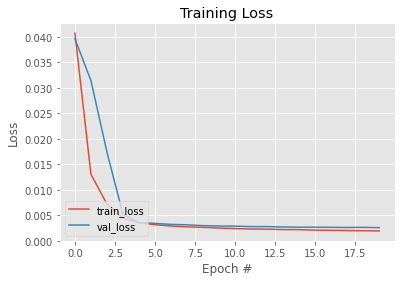

In [ ]:
N = np.arange(len(history.history['loss']))

plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

###테스트 데이터에 대한 복원 실행

In [ ]:
reconstructed = autoencoder.predict(testX)

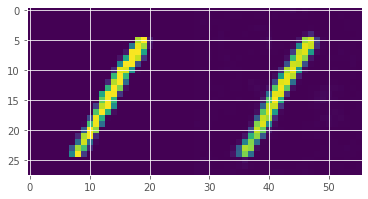

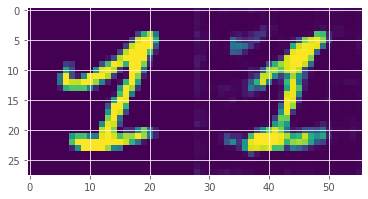

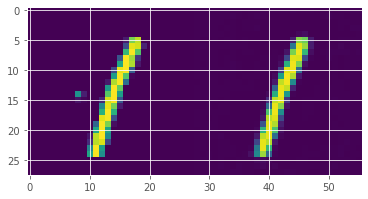

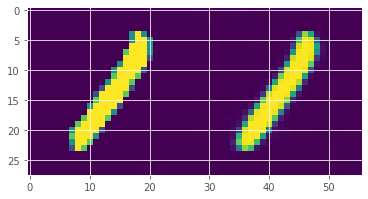

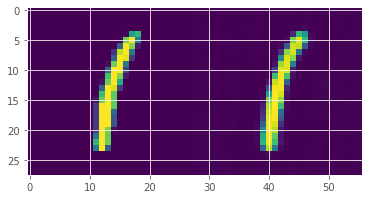

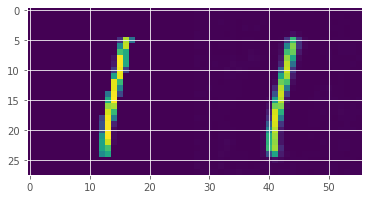

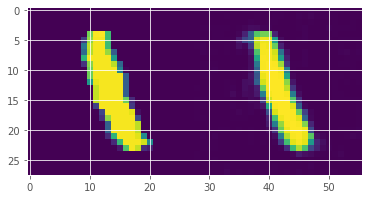

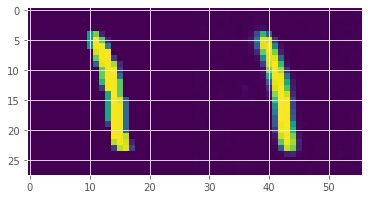

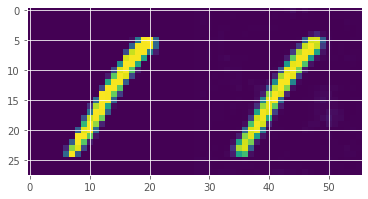

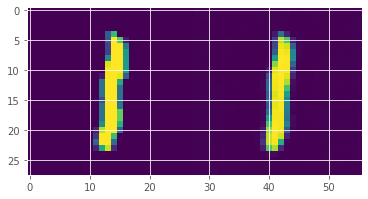

In [ ]:
for i in range(10):
  combined = np.hstack([testX[i], reconstructed[i]]) #원본과, 이상탐지를 같이 그림
  plt.imshow(combined.squeeze())
  plt.show()

## 이상 탐지
학습된 AutoEncoder는 1 영상(정상 영상)의 경우 잘 복원한다. 그러나 그렇지 않은 경우 잘 복원하지 못한다.
<br>
1의 영상은 정상이고, 3의 영상은 비정상이다.
또한 1이외의 정상 역시 비정상이다.
<br>
AutoEncoder를 사용하여 인코딩과 디코딩을 통해 복원하고, 복원된 것이 원본과 차이가 날 수록 비정상인것으로 판단한다.

##복원 실행

In [ ]:
reconstructed = autoencoder.predict(testX)

##차이 계산

In [ ]:
errors = []

for (image, recon) in zip(testX, reconstructed):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - recon) ** 2)
	errors.append(mse)

In [ ]:
plt.hist(errors, bins=100)
plt.show()

데이터의 1/101이 비정상 데이터이다.
<br>
quantile 0.99 이상이 되는 threshold를 구하자.

In [ ]:
threshold = np.quantile(errors, 0.99)
print(threshold)

anomaly Mnist 추가해야됨

#다중 입력

In [ ]:
# model = keras.Sequential()
# model.add(Input((28,28,1)))
# model.add(Conv2D(32, (3, 3)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3, 3)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Flatten())
# model.add(Dense(10, activation='relu'))
# model.add(Dense(10, activation='relu'))
# model.add(Dense(10, activation='softmax'))


from tensorflow.keras import Model

input = Input((28,28,1))
x = Conv2D(32, (3,3))(input) #pre-layer's input 
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3))(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(10, activation='relu')(x)
x = Dense(10, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(input, output) #model code #functional api type
#합치는 경우 functional api type 필수, sequential type은은 순서대로
#다중 입력에 대해서 사용

##데이터 준비

In [ ]:
!git clone https://github.com/emanhamed/Houses-dataset

Cloning into 'Houses-dataset'...
remote: Enumerating objects: 2166, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 2166 (delta 0), reused 0 (delta 0), pack-reused 2165
Receiving objects: 100% (2166/2166), 176.26 MiB | 35.63 MiB/s, done.
Resolving deltas: 100% (20/20), done.


Houses-dataset/
<br>
  Houses Dataset/
  <br>
    100_bathroom.jpg
    <br>
    100_bedroom.jpg
    <br>
    ...
    <br>
    HousesInfo.txt
    <br>

In [ ]:
!head 'Houses-dataset/Houses Dataset/HousesInfo.txt'

4 4 4053 85255 869500
4 3 3343 36372 865200
3 4 3923 85266 889000
5 5 4022 85262 910000
3 4 4116 85266 971226
4 5 4581 85266 1249000
3 4 2544 85262 799000
4 5 5524 85266 1698000
3 4 4229 85255 1749000
4 5 3550 85262 1500000


In [ ]:
import matplotlib

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

In [ ]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os

def load_house_attributes(inputPath):

	cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
	df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)
 
	# determine (1) the unique zip codes and (2) the number of data
	# points with each zip code
	zipcodes = df["zipcode"].value_counts().keys().tolist()
	counts = df["zipcode"].value_counts().tolist()
 
	# loop over each of the unique zip codes and their corresponding
	# count
	for (zipcode, count) in zip(zipcodes, counts):
		# the zip code counts for our housing dataset is *extremely*
		# unbalanced (some only having 1 or 2 houses per zip code)
		# so let's sanitize our data by removing any houses with less
		# than 25 houses per zip code
		if count < 25:
			idxs = df[df["zipcode"] == zipcode].index
			df.drop(idxs, inplace=True)
   
	# return the data frame
	return df

def process_house_attributes(df, train, test):
	# initialize the column names of the continuous data
	continuous = ["bedrooms", "bathrooms", "area"]

	# performin min-max scaling each continuous feature column to
	# the range [0, 1]
	cs = MinMaxScaler()
	trainContinuous = cs.fit_transform(train[continuous])
	testContinuous = cs.transform(test[continuous])
 
	# one-hot encode the zip code categorical data (by definition of
	# one-hot encoding, all output features are now in the range [0, 1])
	zipBinarizer = LabelBinarizer().fit(df["zipcode"])
	trainCategorical = zipBinarizer.transform(train["zipcode"])
	testCategorical = zipBinarizer.transform(test["zipcode"])
 
	# construct our training and testing data points by concatenating
	# the categorical features with the continuous features
	trainX = np.hstack([trainCategorical, trainContinuous])
	testX = np.hstack([testCategorical, testContinuous])
 
	# return the concatenated training and testing data
	return (trainX, testX)  

In [ ]:
IMAGE_SIZE = 32*4
def load_house_images(df, inputPath):

	# initialize our images array (i.e., the house images themselves)
	images = []

	# loop over the indexes of the houses
	for i in df.index.values:
		# find the four images for the house and sort the file paths,
		# ensuring the four are always in the *same order*
		basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
		housePaths = sorted(list(glob.glob(basePath)))
  
		# initialize our list of input images along with the output image
		# after *combining* the four input images
		inputImages = []
		outputImage = np.zeros((IMAGE_SIZE*2, IMAGE_SIZE*2, 3), dtype="uint8")
  
		# loop over the input house paths
		for housePath in housePaths:
			# load the input image, resize it to be IMAGE_SIZExIMAGE_SIZE, and then
			# update the list of input images
			image = cv2.imread(housePath)
			image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
			inputImages.append(image)
   
		# tile the four input images in the output image such the first
		# image goes in the top-right corner, the second image in the
		# top-left corner, the third image in the bottom-right corner,
		# and the final image in the bottom-left corner
		outputImage[0:IMAGE_SIZE, 0:IMAGE_SIZE] = inputImages[0]
		outputImage[0:IMAGE_SIZE, IMAGE_SIZE:IMAGE_SIZE*2] = inputImages[1]
		outputImage[IMAGE_SIZE:IMAGE_SIZE*2, 0:IMAGE_SIZE] = inputImages[2]
		outputImage[IMAGE_SIZE:IMAGE_SIZE*2, IMAGE_SIZE:IMAGE_SIZE*2] = inputImages[3]

		# add the tiled image to our set of images the network will be
		# trained on
		images.append(outputImage)
  
	# return our set of images
	return np.array(images)  

##값 정보 읽기

In [ ]:
df = load_house_attributes("Houses-dataset/Houses Dataset/HousesInfo.txt")

##영상 데이터 읽기

In [ ]:
images = load_house_images(df, "Houses-dataset/Houses Dataset/")
images = images/255.

In [ ]:
print(images.shape)

(362, 256, 256, 3)


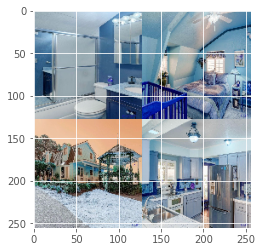

In [ ]:
plt.imshow(images[0])
plt.show()

In [ ]:
(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(df, images, test_size=0.25, random_state=42)

maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice
(trainAttrX, testAttrX) = process_house_attributes(df, trainAttrX, testAttrX)

In [ ]:
print("tainAttrX.shape=", trainAttrX.shape)
print("trainImagesX.shape=", trainImagesX.shape)
print("trainY.shape=", trainY.shape)
print("testAttrX.shape=", testAttrX.shape)
print("testImageX.shape=", testImagesX.shape)
print("testY.shape=", testY.shape)

In [ ]:
# import the necessary packages
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate